The hidden layers in a neural network can be seen as different representations of the input. Do deeper layers learn "better" representations? In a network trained to solve a classification problem, this would mean that deeper layers provide better features than earlier layers. The natural hypothesis is that this is indeed the case. In this post, I test this hypothesis on an network with three hidden layers trained to classify the MNIST dataset. It is shown that deeper layers do in fact produce better representations of the input. 

### Model setup

In [1]:
import tensorflow as tf
import numpy as np
import load_mnist
import matplotlib.pyplot as plt
%matplotlib inline
mnist = load_mnist.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
-

0.9709


The network achieves an accuracy of about 97% after 10000 training steps in batches of 50 (about 1 epoch of the dataset). 

### Increasing representational power

To show increasing representational power, I run logistic regression (supervised) and PCA (unsupervised) models on each layer of the data and show that they perform progressively better with deeper layers.

In [3]:
x_test, y_test = mnist.test.images[:1000], mnist.test.labels[:1000]

y_train_single = np.sum((mnist.train.labels[:1000] * np.array([0,1,2,3,4,5,6,7,8,9])),axis=1)
y_test_single = np.sum((y_test * np.array([0,1,2,3,4,5,6,7,8,9])),axis=1)

x_arr_test = [x_test] + sess.run([l1,l2,l3],feed_dict={x:x_test,y_:y_test})
x_arr_train = [mnist.train.images[:1000]] + sess.run([l1,l2,l3],feed_dict={x:mnist.train.images[:1000],y:mnist.train.labels[:1000]})

### Logistic Regression

In [4]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()

for idx, i in enumerate(x_arr_train):
    log_reg.fit(i,y_train_single)
    print("Layer " + str(idx) + " accuracy is: " + str(log_reg.score(x_arr_test[idx],y_test_single)))

Layer 0 accuracy is: 0.828
Layer 1 accuracy is: 0.925
Layer 2 accuracy is: 0.953
Layer 3 accuracy is: 0.972


In support of the hypothesis, logistic regression performs progressively better the deeper the representation. There appear to be decreasing marginal returns to each additional hidden layer, and it would be interesting to see if this pattern holds up for deeper / more complex models. 

### PCA

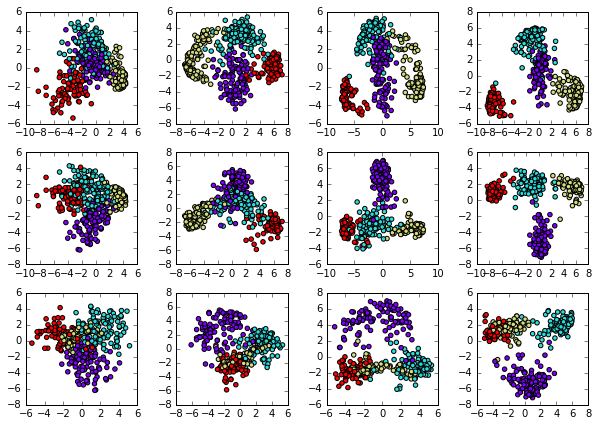

In [5]:
from sklearn.decomposition import PCA
from matplotlib import cm
def plot_mnist_pca(axis, x, ix1, ix2, colors, num=1000):
    pca = PCA()
    pca.fit(x)
    x_red = pca.transform(x)
    axis.scatter(x_red[:num,ix1],x_red[:num,ix2],c=colors[:1000],cmap=cm.rainbow_r)

def plot(list_to_plot):
    fig,ax = plt.subplots(3,4,figsize=(8.5,6))
    fig.tight_layout()
    perms = [(0,1),(0,2),(1,2)]
    colors = y_test_single

    index = np.zeros(colors.shape)
    for i in list_to_plot:
        index += (colors==i)

    for row, axis_row in enumerate(ax):
        for col, axis in enumerate(axis_row):
             plot_mnist_pca(axis, x_arr_test[col][index==1], perms[row][0], perms[row][1], colors[index==1], num=1000)

plot(range(4))

Each row of the above grid plots combinations (pairs) of the first three principal components with respect to the numbers 0, 1, 2 and 3 (using only 4 numbers at a time makes the separation more visible). The columns, from left to right, correspond to the input layer, the first hidden layer, the second hidden layer and the final hidden layer. 

In support of the hypothesis, the principal components of deeper layers provide visibly better separation of the data than earlier layers. 

### A failed experiment: teaching the neural network features

I had hypothesized that we could use the most prominent features (the top three principal components) of the final hidden layer to train a new neural network and have it perform better. For each training example, in addition to predicting the classification, the new network also performs a regression on the top three principal components of that training example's third hidden layer representation according to the first model. The training step backpropagates both the classification error and the regression error. 

Unfortunately, this approach did not provide any noticeable improvement over the original model. 

In [ ]:
pca = PCA()
l3_train = l3.eval(feed_dict={x:mnist.train.images})
l3_test  = l3.eval(feed_dict={x:mnist.test.images})

pca.fit(l3_train)
y_new_train = pca.transform(l3_train)[:,:3]
y_new_test = pca.transform(l3_test)[:,:3]

saver.restore(sess, '/tmp/initial_variables.ckpt')

# create new placeholder for 3 new variables
y_3newfeatures_ = tf.placeholder("float", shape=[None, 3])

# add linear regression for new features
w = weight_variable([100,3])
b = bias_variable([3])
y_3newfeatures = tf.matmul(l1,w) + b

sess.run(tf.initialize_all_variables())

new_feature_loss = 1e-1*tf.reduce_sum(tf.abs(y_3newfeatures_-y_3newfeatures))

train_step_new_features = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy + new_feature_loss)

new_accuracy = []
for i in range(10000):
    start = (50*i) % 54950
    end = start + 50
    train_step_new_features.run(feed_dict={x: mnist.train.images[start:end], y_: mnist.train.labels[start:end],y_3newfeatures_:y_new_train[start:end]})
    if i % 100 == 0:
        acc, ce, lr = sess.run([accuracy, cross_entropy, new_feature_loss],feed_dict={x:mnist.test.images,y_:mnist.test.labels,y_3newfeatures_:y_new_test})
        new_accuracy.append(acc)
        print("Accuracy: " + str(acc) + " -- Cross entropy: " + str(ce) + " -- New feature loss: " + str(lr),end="\r")
        
print(new_accuracy[-1])

In [ ]:
fig, ax = plt.subplots()

ax.plot(base_accuracy, label='Base')
ax.plot(new_accuracy, label='New')
ax.set_xlabel('Training steps')
ax.set_ylabel('Accuracy')
ax.set_title('Base vs New Accuracy')
ax.legend(loc=4)
plt.show()